In [6]:
# The goal of this notebook is to lay the foundation
# for two types of supervised machine learning classifiers.
from collections import Counter
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, hstack
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import ast
import pandas as pd
import numpy as np

Principal Component Analysis 

In [7]:
## Step 0: Filter Out Unneeded Cols
def condition_raw_data(raw_df):
    """
    Consume a dataframe

    Return a DF with the musical attributes and genre columns only
    """
    # rename artist genres to be called genre
    raw_df.rename(columns={'artist_genres': 'genre'}, inplace=True)
    # features and y val cols.
    required_cols = ['danceability', 'energy', 'key', 'loudness', 'mode', 
                'speechiness', 'acousticness', 'instrumentalness', 
                'liveness', 'valence', 'tempo', 'time_signature',
                'duration_ms', 'genre'
       ]
    # remove unneccessary cols
    raw_df = raw_df[required_cols]
    return raw_df
## Step 1: Break the data into a training and a test set
def generate_train_test(tracks_df, random_val=42, split_ratio=0.8):
    """
    inputs:
        a dataframe containing song attributes and genre.
        random val for repeatability
        split_ratio = decimal pct of samples to use for training.
    returns:
        two dataframes train_df and test_df
    """
    # step 1 shuffle the df
    temp_df = tracks_df.sample(random_state=random_val, frac=1.0)
    # establish a number to split the frame at.
    num_train_samples = int(split_ratio*len(tracks_df))
    # split the DF into two sets train and test
    return np.split(temp_df, [num_train_samples])
# PCA
# goal apply PCA to the data set. Evaluate impact on F1
def apply_biplot_pca(train_df):
    """
    read in the training data for a dataframe
    apply dimmensionality reduction

    Special version for plot. Return PCA object.
    """
    # start off with stock settings
    pca = PCA(n_components=13)
    train_df.reset_index(inplace=True, drop=True)
    X_cols = [col for col in train_df.columns if col != 'genre']
    myScaler = StandardScaler()
    X_train = myScaler.fit_transform(train_df[X_cols])
    # only use the training data to fit the pca model
    pca.fit(X_train)
    return pca.transform(X_train), pca
# PCA
# goal apply PCA to the data set. Evaluate impact on F1
def apply_pca(train_df, test_df, n_dim = 2):
    """
    read in the training data for a dataframe
    apply dimmensionality reduction

    return modified train and test sets
    """
    # start off with stock settings
    pca = PCA(n_components=n_dim)
    train_df.reset_index(inplace=True, drop=True)
    test_df.reset_index(inplace=True, drop=True)
    X_cols = [col for col in train_df.columns if col != 'genre']
    myScaler = StandardScaler()
    X_train = myScaler.fit_transform(train_df[X_cols])
    X_test = myScaler.transform(test_df[X_cols])
    # only use the training data to fit the pca model
    pca.fit(X_train)
    # lesson learned here you need to reset the index so that pandas merges the labels
    # back in correctly
    pca_train_df = pd.DataFrame(pca.transform(X_train))
    pca_train_df['genre'] = train_df['genre']

    pca_test_df = pd.DataFrame(pca.transform(X_test))
    pca_test_df['genre'] = test_df['genre']
    return pca_train_df, pca_test_df

# Step 2: train a classifier using the training set
def train_logistic_regression(train_df, random_val=42, data_type='spotify'):
    """
    inputs:
        A dataframe of training data
        A random value for repeatability

    returns:
        a trained classifier.
    """
    X = train_df[[col for col in train_df.columns if col != 'genre']]
    y = train_df['genre']
    # Step 2 create the classifier
    clf = LogisticRegression(random_state=random_val, solver = 'newton-cg', multi_class='multinomial', max_iter=1000)
    # fit the classifier
    return clf.fit(X, y)
# Step 3: train a random forest classifier
def train_random_forest(train_df, random_val=42):
    """
    inputs:
        A dataframe of training data
        A random value for repeatability

    returns:
        a trained classifier.
    """
    # Step 1 create X and y
    X = train_df[[col for col in train_df.columns if col != 'genre']]
    y = train_df['genre']
    # Step 2 create the classifier
    clf = RandomForestClassifier(random_state=random_val, n_estimators=1000, max_features='sqrt', criterion='entropy', max_depth=30)
    # fit the classifier
    return clf.fit(X, y)
# Step 4: test the classifiers
def test_clf_model(clf, test_df):
    """
    inputs:
        testing set
        clf
    returns:
        f1 score
    """
    # step 1 create an X_test and y_test
    X_test = test_df[[col for col in test_df.columns if col != 'genre']]
    y_test = test_df['genre']
    # step 2 predict the genre for the test set
    y_pred = clf.predict(X_test)
    # step 3 calculate the average F1 score for all classes
    return f1_score(y_test, y_pred, average='macro')
# Create a dummy classifier for comparison
def create_dummy(train_df, random_val=42, data_type='spotify'):
    """
    Train a uniform dummy classifier for performance evaluation
    """
    X = train_df[[col for col in train_df.columns if col != 'genre']]
    y = train_df['genre']
    random_clf = DummyClassifier(strategy='uniform', random_state=random_val)
    random_clf.fit(X, y)
    return random_clf


Implement Principal Component Analysis

In [13]:
# implement pca function
raw_df = pd.read_csv('../raw_spotify_data/pure_genre_data.csv')
clean_df = condition_raw_data(raw_df)
train, test = generate_train_test(clean_df, 42, 0.8)
# transform train and test data into principal components
train, test = apply_pca(train, test, 3)
# train classifiers using transformed data
lr_clf = train_logistic_regression(train, 42)
rf_clf = train_random_forest(train)
dum_clf = create_dummy(train)
lr_score = test_clf_model(lr_clf, test)
rf_score = test_clf_model(rf_clf, test)
dum_score = test_clf_model(dum_clf, test)
print(f'random forest: {rf_score}')
print(f'logistic regression: {lr_score}')
print(f'dummy classifier: {dum_score}')

random forest: 0.48092971984058375
logistic regression: 0.4421528377129066
dummy classifier: 0.1348860045008973


In [10]:
# integrate all functions to generate biplot and scree plot
raw_df = pd.read_csv('../raw_spotify_data/pure_genre_data.csv')
clean_df = condition_raw_data(raw_df)
train, test = generate_train_test(clean_df, 42, 0.8)
train, pca = apply_biplot_pca(train)

Create Bi-Plot

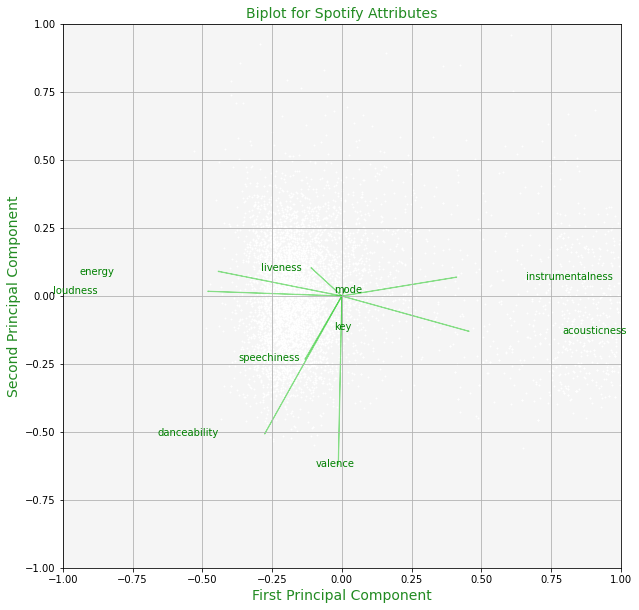

In [11]:
# generate biplot for features vs first 2 principal components
feature_names = ['danceability', 'energy', 'key', 'loudness', 'mode', 
                'speechiness', 'acousticness', 'instrumentalness', 
                'liveness', 'valence', 'tempo', 'time_signature',
                'duration_ms']

# This function was heavily influenced by the week 1 assignment in Unsupervised Machne Learning
# Week 1
def biplot(score, coeff, maxdim, pcax, pcay, labels=None):
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n = min(coeff.shape[0], maxdim)
    scalex = 2.0/(xs.max()- xs.min())
    scaley = 2.0/(ys.max()- ys.min())
    text_scale_factor = 2
    fig, ax = plt.subplots()
    ax.scatter(xs*scalex, ys*scaley, s=1, color='w')
    for i in range(n):
        ax.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='limegreen',alpha=0.5) 
        ax.text(coeff[i,pca1]* text_scale_factor, coeff[i,pca2], labels[i], color='g', ha='center', va='center')
    ax.set_title('Biplot for Spotify Attributes',color= 'forestgreen', fontsize = 14)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xlabel('First Principal Component', color= 'forestgreen', fontsize = 14)
    ax.set_ylabel("Second Principal Component", color = 'forestgreen', fontsize = 14)
    ax.set_facecolor('whitesmoke')
    fig.set_size_inches(10,10)
    ax.grid()

biplot(train, np.transpose(pca.components_[0:2, :]), 10, 1, 2, labels=feature_names) 
     

Create Scree Plot

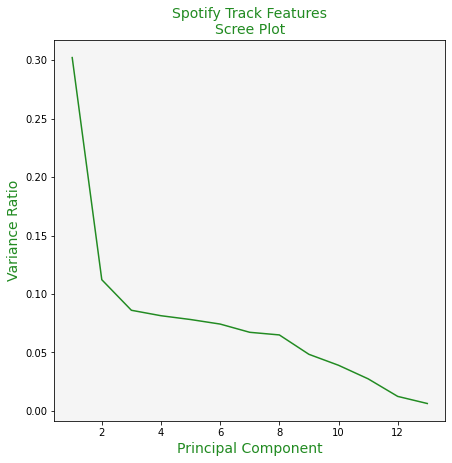

In [12]:
num_components = np.arange(pca.n_components_) + 1
fig, ax = plt.subplots()
ax.set_title('Spotify Track Features\nScree Plot', fontsize = 14, color = 'forestgreen')
ax.plot(num_components, pca.explained_variance_ratio_, color='forestgreen')
ax.set_ylabel('Variance Ratio', fontsize=14, color='forestgreen')
ax.set_xlabel('Principal Component', fontsize = 14, color='forestgreen')
ax.set_facecolor('whitesmoke')
fig.set_size_inches(7, 7)
